# Tracking through the map of a magnetic field
We want to transport a bunch of Carbon ions through the realistic field map of a strongly bent dipole magnet.

In [1]:
import RF_Track as RFT
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time
import pickle

In [2]:
import scripts

## Define the key parameters
In the function ```init_ion```, we specify the key parameters of the reference particle.

In [3]:
ion = scripts.init_ion()

## Let's load the field map

In [4]:
def init_volume():

    with open('data/Dipole_Fieldmap.pkl', 'rb') as f:
        field = pickle.load(f)

    # Create RF-Track element
    S = RFT.RF_FieldMap (0.0, 0.0, 0.0,
                              field['Bx'],
                              field['By'],
                              field['Bz'],
                              field['x_min_mm']/1e3,
                              field['y_min_mm']/1e3,
                              field['hx']/1e3,
                              field['hy']/1e3,
                              field['hz']/1e3, -1.0, 0.0, 0.0)

    # Init Volume
    V = RFT.Volume()
    V.add_ref (S, 0, 0, 0, 'center')
    
    V.odeint_algorithm = 'rk2'
    V.odeint_epsabs = 1e-8
    V.tt_dt_mm = 10
    V.dt_mm = 0.1 # mm/c

    # Define the reference particle
    ion = scripts.init_ion ()
    P0 = RFT.Bunch6dT (ion['mass'], 0, ion['Z'], np.array([ 0., 0., 0., 0., 0., ion['P_ref'] ]).T)
    
    # Set boudaries
    traj_len = 700 # mm
    t_mm = traj_len / ion['V_ref'] # [mm/c]
    V.set_s0(0.0)
    V.set_s1(P0, t_mm)

    return V
    

We can initialize the volume now

In [5]:
V = init_volume()

## Let's plot the field
Using get_field over the plane $XZ$

In [6]:
Xa = np.linspace(-150, 150, 101)  # mm
Za = np.linspace(-700, 700, 201)  # mm
# Create the meshgrid for the XZ plane
X, Z = np.meshgrid(Xa, Za)

X_flat = X.ravel()  # Equivalent to X(:) in Octave
Z_flat = Z.ravel()  # Equivalent to Z(:) in Octave

# Pass flattened X, Z, and fixed values for other parameters
E, B = V.get_field(X_flat, 0, Z_flat, 0)

# Reshape the components of B to match the original grid shape
Bx = B[:, 0].reshape(X.shape)
By = B[:, 1].reshape(X.shape)
Bz = B[:, 2].reshape(X.shape)

Here we plot it

In [7]:
# Plot the data
plt.figure()
plt.pcolormesh(Za, Xa, By.T)  # Transpose By to match Octave's orientation
h = plt.colorbar()  # Add a colorbar

# Set axis labels
plt.xlabel('z [mm]')
plt.ylabel('x [mm]')
h.set_label('$B_y$ [T]')  # Label for the colorbar

# Show the plot
plt.show()

## Let's perform tracking
We perform tracking in Lattice, to ease integration with downstream beamline elements. First, let's create a bunch.

In [8]:
Twiss = RFT.Bunch6d_twiss()
Twiss.beta_x = 1 # m
Twiss.beta_y = 1 # m
Twiss.emitt_x = 1 # mm.mrad, normalised emittance 
Twiss.emitt_y = 1 # mm.mrad
Twiss.sigma_t = 1 # mm/c
Twiss.sigma_pt = 1 # permille, normalised energy spread
Twiss.disp_x = 0 # m, initial dispersion

In [9]:
N_particles = 1000

B0 = RFT.Bunch6d_QR (ion['mass'], 0.0, ion['Z'], ion['P_ref'], Twiss, N_particles)

In [10]:
V.set_tt_nsteps(10)

L = RFT.Lattice()
L.append_ref(V)

start_time = time.time()
B1 = L.track(B0)
end_time = time.time()
print(f'Elapsed time is {end_time - start_time:.2f} seconds')

Elapsed time is 2.37 seconds


Let's retrieve the phase space and the transport table

In [11]:
I1 = B1.get_phase_space('%x %Px %y %Py %t %E')

TT = L.get_transport_table('%S %beta_x %beta_y %disp_x %disp_px %emitt_x %emitt_y %emitt_4d %emitt_6d')

## Let's do some plots

In [12]:
plt.figure()
plt.plot(TT[:, 0], TT[:, 1], label='beta_x', linewidth=2)  # Plot beta_x
plt.plot(TT[:, 0], TT[:, 2], label='beta_y', linewidth=2)  # Plot beta_y

# Add legend
plt.legend(loc='best')
plt.xlabel('S [m]')
plt.ylabel('beta function [m]')
plt.show()

In [13]:
plt.figure()
plt.plot(TT[:, 0], TT[:, 5], label='emitt_x', linewidth=2)  # Plot emitt_x (6th column in Python is index 5)
plt.plot(TT[:, 0], TT[:, 6], label='emitt_y', linewidth=2)  # Plot emitt_y (7th column in Python is index 6)

# Add legend
plt.legend(loc='best')

# Add labels
plt.xlabel('S [m]')
plt.ylabel('normalised emittance [mm.mrad]')

# Show the plot
plt.show()

# Interlude
### Fitting the transfer matrix

In [14]:
M0 = B0.get_phase_space('%x %xp %y %yp %dt %pt')
M1 = B1.get_phase_space('%x %xp %y %yp %dt %pt')

x0  = M0[:,0]
xp0 = M0[:,1]
y0  = M0[:,2]
yp0 = M0[:,3]
t0  = M0[:,4]
d0  = M0[:,5]

x1  = M1[:,0]
xp1 = M1[:,1]
y1  = M1[:,2]
yp1 = M1[:,3]
t1  = M1[:,4]
d1  = M1[:,5]

I = np.ones(x0.size)
I1 = np.array([x1,xp1,y1,yp1,t1,d1]).T
I0 = [I, # K - 0th order
      x0,xp0,y0,yp0,t0,d0, # R - 1st order
      x0**2,xp0**2,y0**2,yp0**2,t0**2*d0**2, # T 2nd-order
      x0*xp0,x0*y0,x0*yp0,x0*t0,x0*d0, # T
      xp0*y0,xp0*yp0,xp0*t0,xp0*d0, # T
      y0*yp0,y0*t0,y0*d0, # T
      yp0*t0,yp0*d0, # T
      t0*d0, # T
      d0*d0*d0,d0*d0*t0,d0*d0*x0,d0*d0*xp0,d0*d0*y0, # U - 3rd order
      d0*d0*yp0,d0*t0*t0,d0*t0*x0,d0*t0*xp0,d0*t0*y0, # U
      d0*t0*yp0,d0*x0*x0,d0*x0*xp0,d0*x0*y0,d0*x0*yp0, # U
      d0*xp0*xp0,d0*xp0*y0,d0*xp0*yp0,d0*y0*y0, # U
      d0*y0*yp0,d0*yp0*yp0,t0*t0*t0,t0*t0*x0,t0*t0*xp0, # U
      t0*t0*y0,t0*t0*yp0,t0*x0*x0,t0*x0*xp0,t0*x0*y0, # U
      t0*x0*yp0,t0*xp0*xp0,t0*xp0*y0,t0*xp0*yp0, # U
      t0*y0*y0,t0*y0*yp0,t0*yp0*yp0,x0*x0*x0,x0*x0*xp0, # U
      x0*x0*y0,x0*x0*yp0,x0*xp0*xp0,x0*xp0*y0, # U
      x0*xp0*yp0,x0*y0*y0,x0*y0*yp0,x0*yp0*yp0, # U
      xp0*xp0*xp0,xp0*xp0*y0,xp0*xp0*yp0,xp0*y0*y0, # U
      xp0*y0*yp0,xp0*yp0*yp0,y0*y0*y0,y0*y0*yp0, # U
      y0*yp0*yp0,yp0*yp0*yp0] # U
I0 = np.array(I0).T

M = np.linalg.lstsq(I0, I1, rcond=None)[0].T
K = M[:,0]
R = M[:,1:7]
T = M[:,7:28]
U = M[:,28:]

K.shape, R.shape, T.shape

# Tracking
MT = np.concatenate((K.reshape(6,1), R, T, U), axis=1)
I1_predicted = (MT @ I0.T).T

In [15]:
np.linalg.det(R)

1.0003308776203093

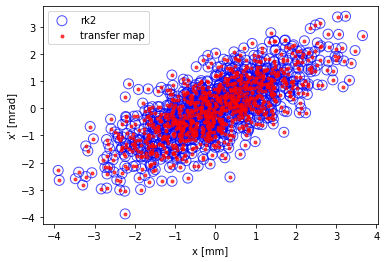

In [16]:
plt.figure()
plt.scatter(I1[:, 0], I1[:, 1], s=100, marker='o', label='rk2', facecolors='none', edgecolors='b', alpha=0.7)
plt.scatter(I1_predicted[:, 0], I1_predicted[:, 1], c='r', marker='.', label='transfer map', alpha=0.7)
plt.xlabel('x [mm]')
plt.ylabel("x' [mrad]")  # Corrected second xlabel to ylabel
plt.legend(loc='best')  # Automatically place the legend
plt.show()